In [1]:
# Manual DGP Simulation
import numpy as np
normal_traffic = np.random.randint(20, 50, 980)
spike_traffic = np.random.randint(1000, 5000, 20)
latency_logs = np.concatenate([normal_traffic, spike_traffic])

In [2]:
def calculate_mad(data):
    # 1. Compute the median
    median = np.median(data)
    
    # 2. Compute absolute deviations from the median
    absolute_deviations = np.abs(data - median)
    
    # 3. Return the median of those deviations
    mad = np.median(absolute_deviations)
    
    return mad

#Audit Metrics

In [3]:
mean_latency = np.mean(latency_logs)
median_latency = np.median(latency_logs)
mad_latency = calculate_mad(latency_logs)

print("Mean:", mean_latency)
print("Median:", median_latency)
print("MAD:", mad_latency)

Mean: 97.99
Median: 35.0
MAD: 7.0


Phase 2: Probability Audit

In [5]:
def bayesian_audit(prior, sensitivity, specificity):
    
    # False positive rate
    false_positive_rate = 1 - specificity
    
    # Bayes numerator
    numerator = sensitivity * prior
    
    # Bayes denominator
    denominator = numerator + false_positive_rate * (1 - prior)
    
    posterior = numerator / denominator
    
    return posterior


###Assumptions

In [6]:
sensitivity = 0.98
specificity = 0.98

###Scenario A (Bootcamp): Base Rate = 50%

In [7]:
bayesian_audit(0.50, 0.98, 0.98)

0.98

###Scenario B (Econ Class): Base Rate = 5%

In [8]:
bayesian_audit(.05, .98, .98)

0.7205882352941175

###Scenario C (Honors Seminar): Base Rate = 0.1%

In [9]:
bayesian_audit(.001, .98, .98)

0.04675572519083965

#Phase 3: The Bias Audit
###Detecting Sample Ratio Mismatch

In [10]:
import numpy as np

observed = np.array([50250, 49750])
expected = np.array([50000, 50000])

###Chi-Sq Calculation

In [11]:
chi_square = 0

for o, e in zip(observed, expected):
    chi_square += (o - e)**2 / e

print("Chi-Square Statistic:", chi_square)

Chi-Square Statistic: 2.5


The Chi Square statistic of 2.5 is less than the critical value of 3.84. Therefore, there is insufficient evidence to reject the null hypothesis.

#The "Memecoin Graveyard" Simulation

Tokens simulated: 10,000
Survivors (top 1%): 100
Mean Peak Market Cap (ALL):        $217,687,874
Mean Peak Market Cap (SURVIVORS):  $21,761,888,375
Survivors/All mean ratio:          99.97x


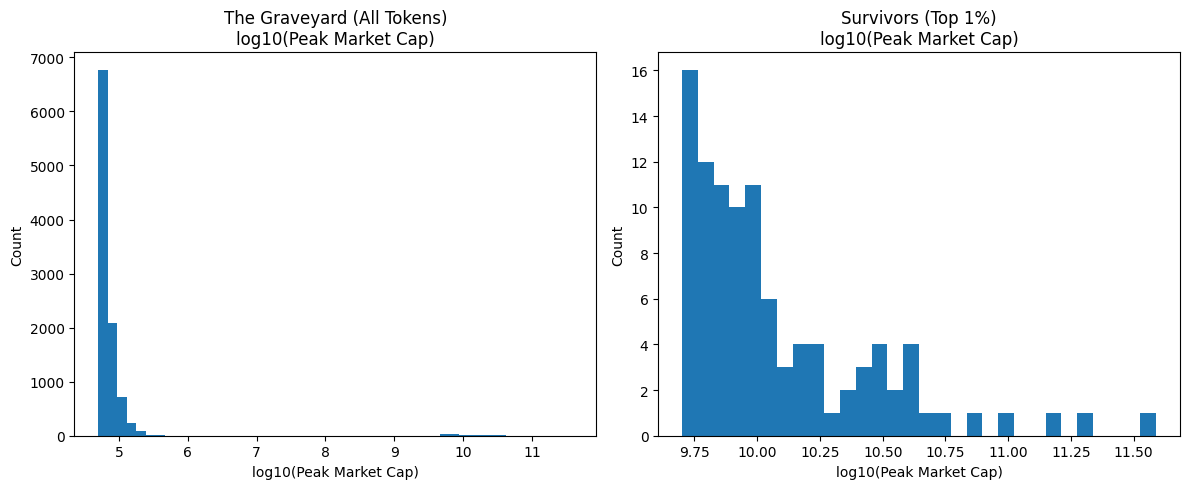

In [12]:
# Survivorship Bias in Crypto: Simulation + Visualization
# - 10,000 token launches
# - Peak Market Cap follows a heavy-tailed (power law) process
# - Compare "graveyard" (all tokens) vs "survivors" (top 1%)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

N = 10_000
SURVIVOR_PCT = 0.01
K = int(N * SURVIVOR_PCT)

# -----------------------------
# 1) Data Generating Process
# -----------------------------
# To make "99% near zero" explicit, use a 2-regime Pareto:
# - 99%: small-cap graveyard (tight near a small minimum)
# - 1%: moonshots (still Pareto, but much larger scale + fatter tail)
#
# NOTE: This is still "power law" behavior (Pareto) in both regimes,
# but reflects the reality that most launches go nowhere while a tiny
# fraction become massive.

# 99% small caps: Pareto concentrated near a small minimum
small_n = N - K
small_caps = (rng.pareto(a=3.5, size=small_n) + 1.0) * 50_000   # min ~50k, most near min

# 1% moonshots: Pareto with a fatter tail + much higher scale
moon_caps = (rng.pareto(a=1.2, size=K) + 1.0) * 5_000_000_000  # min ~5B, some enormous

peak_market_cap = np.concatenate([small_caps, moon_caps])
rng.shuffle(peak_market_cap)  # mix them up (token launches are unlabeled ex-ante)

# -----------------------------
# 2) Create DataFrames
# -----------------------------
df_all = pd.DataFrame({
    "token_id": np.arange(1, N + 1),
    "peak_market_cap": peak_market_cap
})

# Survivors = top 1% by peak market cap
threshold = df_all["peak_market_cap"].quantile(1 - SURVIVOR_PCT)
df_survivors = df_all[df_all["peak_market_cap"] >= threshold].copy()

# -----------------------------
# 3) Evaluate: Show survivorship bias numerically
# -----------------------------
mean_all = df_all["peak_market_cap"].mean()
mean_survivors = df_survivors["peak_market_cap"].mean()

print(f"Tokens simulated: {N:,}")
print(f"Survivors (top {int(SURVIVOR_PCT*100)}%): {len(df_survivors):,}")
print(f"Mean Peak Market Cap (ALL):        ${mean_all:,.0f}")
print(f"Mean Peak Market Cap (SURVIVORS):  ${mean_survivors:,.0f}")
print(f"Survivors/All mean ratio:          {mean_survivors/mean_all:,.2f}x")

# -----------------------------
# 4) Visualize: Dual histograms (log scale)
# -----------------------------
# Use log10 market caps so both the graveyard and winners are visible.
# Add a small epsilon to avoid log(0) issues (though our DGP stays > 0).
eps = 1.0
log_all = np.log10(df_all["peak_market_cap"] + eps)
log_surv = np.log10(df_survivors["peak_market_cap"] + eps)

plt.figure(figsize=(12, 5))

# Left: The Graveyard (all tokens)
plt.subplot(1, 2, 1)
plt.hist(log_all, bins=50)
plt.title("The Graveyard (All Tokens)\nlog10(Peak Market Cap)")
plt.xlabel("log10(Peak Market Cap)")
plt.ylabel("Count")

# Right: Survivors (top 1% only)
plt.subplot(1, 2, 2)
plt.hist(log_surv, bins=30)
plt.title("Survivors (Top 1%)\nlog10(Peak Market Cap)")
plt.xlabel("log10(Peak Market Cap)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()
